In [1]:
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle

In [2]:
from dateutil.parser import parse
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None #to run loop quicker without warnings

In [3]:
#name = 'bpi_2012'
name = 'bpi_2013'
#name = 'helpdesk'
args = {
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'input_dir': '../input/{}/'.format(name),  
    'train_pct': 0.6,
    'val_pct': 0.2,
    'anomaly_pct': 0.1,
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir('../input/'):
    os.makedirs('../input/')
    
if not os.path.isdir(args.input_dir):
    os.makedirs(args.input_dir)

In [5]:
sys.path.insert(0, './../utils/')
from utils import *

# Load data

In [6]:
# Only consider Case, Activity, Timestamp
cols = ['CaseID', 'Activity', 'CompleteTimestamp']

# For Timestamp: Convert to time
if name == 'helpdesk':
    data = pd.read_csv(args.data_dir + args.data_file)
else:
    data = pd.read_csv(args.data_dir + args.data_file, usecols=['Case ID', 'Activity', 'Complete Timestamp'])
    data['Case ID'] = data['Case ID'].apply(lambda x: x.split(' ')[1])
    

# Format for each column     
data.columns = cols
data['CompleteTimestamp'] = pd.to_datetime(data['CompleteTimestamp'], errors='coerce')
data['CaseID'] = data['CaseID'].apply(pd.to_numeric)

In [7]:
data.head()

,CaseID,Activity,CompleteTimestamp
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42
1,1,Accepted-In Progress,2012-03-15 19:53:52
2,1,Accepted-Assigned,2012-03-15 19:56:17
3,1,Accepted-In Progress,2012-03-15 20:09:05
4,1,Completed-Closed,2012-03-15 20:11:33


In [8]:
groupByCase = data.groupby(['CaseID'])
duration_df = pd.DataFrame(pd.DataFrame(columns=list(data)+['Duration', 'CumDuration']))
                           
for case, group in groupByCase:
    group = calculateDuration(group)
    group = calculateCumDuration(group)
    group['Duration'] = group['Duration'].apply(convert2seconds)
    group['CumDuration'] = group['CumDuration'].apply(convert2seconds)
    duration_df = duration_df.append(group)

In [9]:
duration_df.head(10)

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0
5,2,Accepted-In Progress,2006-11-07 18:00:36,0.0,0.0
6,2,Accepted-In Progress,2006-11-07 21:05:44,11108.0,11108.0
7,2,Accepted-Wait,2009-12-02 22:24:32,96859128.0,96870236.0
8,2,Accepted-In Progress,2011-09-03 14:09:09,55266277.0,152136513.0
9,2,Accepted-In Progress,2012-01-20 18:23:24,12024855.0,164161368.0


In [10]:
groupByActivity = duration_df.groupby(['Activity'])
statistics_storage = {}

for act, act_data in groupByActivity:
    act_storage = {}
    act_storage[act] = {}
    mean_value = act_data['Duration'].mean()
    std_value = act_data['Duration'].std()
    act_storage[act]['mean'] = mean_value
    act_storage[act]['std'] = std_value
    statistics_storage.update(act_storage)

In [11]:
print('Descriptive statistics: \n{}'.format(statistics_storage))

Descriptive statistics: 
{'Accepted-Assigned': {'std': 7115575.8771717735, 'mean': 2284207.5146579803}, 'Unmatched-Unmatched': {'std': 1613426.676996954, 'mean': 659730.09999999998}, 'Completed-Closed': {'std': 9756199.0950356536, 'mean': 4487671.0242811497}, 'Accepted-Wait': {'std': 9675577.7800667603, 'mean': 3474376.5730550284}, 'Queued-Awaiting Assignment': {'std': 4089422.3905510097, 'mean': 1000673.2914285715}, 'Accepted-In Progress': {'std': 11479844.398664003, 'mean': 3862876.8098499672}, 'Completed-Cancelled': {'std': 48530.936786068058, 'mean': 28252.333333333332}}


# Explore data

In [12]:
duration_df.head(10)

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0
5,2,Accepted-In Progress,2006-11-07 18:00:36,0.0,0.0
6,2,Accepted-In Progress,2006-11-07 21:05:44,11108.0,11108.0
7,2,Accepted-Wait,2009-12-02 22:24:32,96859128.0,96870236.0
8,2,Accepted-In Progress,2011-09-03 14:09:09,55266277.0,152136513.0
9,2,Accepted-In Progress,2012-01-20 18:23:24,12024855.0,164161368.0


In [13]:
act_list = duration_df['Activity'].unique()
print('Activity: {}'.format(act_list))

Activity: ['Queued-Awaiting Assignment' 'Accepted-In Progress' 'Accepted-Assigned'
 'Completed-Closed' 'Accepted-Wait' 'Unmatched-Unmatched'
 'Completed-Cancelled']


In [72]:
def histogram_plot(activity):
    selected_df = duration_df[duration_df['Activity']==activity]['Duration']
    selected_df.hist()
    plt.axvline(selected_df.mean(), color='w', linestyle='dashed', linewidth=2)
    plt.axvline(selected_df.mean()+selected_df.std(), color='r', linestyle='dashed', linewidth=2)
    plt.title('Histogram of '+ act)
    plt.savefig(args.input_dir + 'histogram_'+act)
    plt.show()
    plt.close()

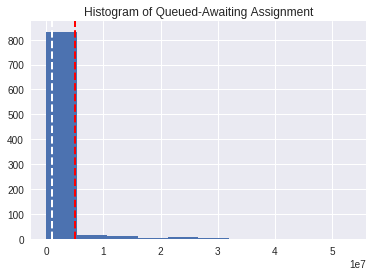

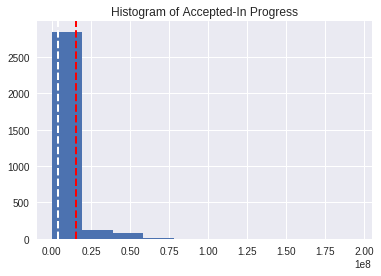

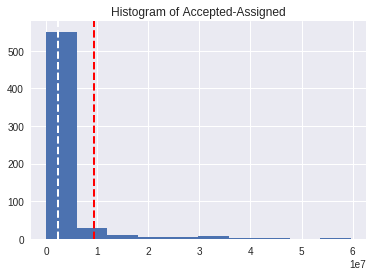

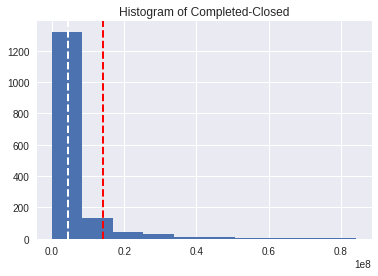

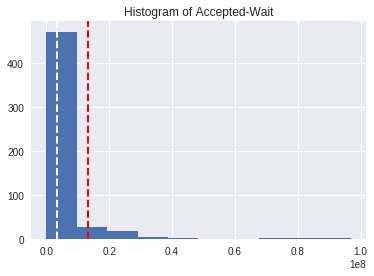

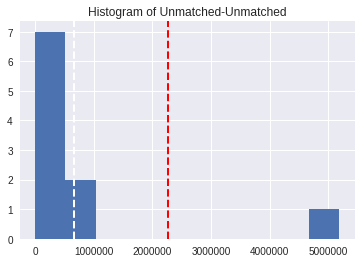

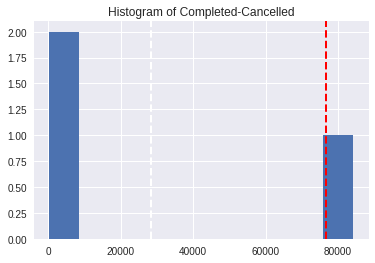

In [73]:
for act in act_list:
    histogram_plot(act)

# Introduce anomalous data

In [16]:
data.head()

,CaseID,Activity,CompleteTimestamp
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42
1,1,Accepted-In Progress,2012-03-15 19:53:52
2,1,Accepted-Assigned,2012-03-15 19:56:17
3,1,Accepted-In Progress,2012-03-15 20:09:05
4,1,Completed-Closed,2012-03-15 20:11:33


In [17]:
duration_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0


In [18]:
anomaly_num = int(data.shape[0]*(data.shape[1]-1)*args.anomaly_pct)
anomalous_act_num = int(anomaly_num/2)
anomalous_time_num = anomaly_num - anomalous_act_num

print('Number of anomalous values: {}'.format(anomaly_num))
print('Number of anomalous activities: {}'.format(anomalous_act_num))
print('Number of anomalous time: {}'.format(anomalous_time_num))

Number of anomalous values: 1332
Number of anomalous activities: 666
Number of anomalous time: 666


## Activity

**Mutation:**
- Swap 2 activities within a case
- Duplicate 1 activity

In [19]:
groupByCase = duration_df.groupby(['CaseID'])

In [20]:
len(groupByCase)

1487

In [21]:
anomalous_act_index = []
caseid_list = []
temp_df = duration_df.copy()
temp_df['AnomalousActivity'] = temp_df['Activity'].copy()
temp_df['ActivityLabel'] = 0

In [22]:
temp_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousActivity,ActivityLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,Queued-Awaiting Assignment,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,Accepted-In Progress,0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,Accepted-Assigned,0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,Accepted-In Progress,0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,Completed-Closed,0


In [23]:
while len(anomalous_act_index) < anomalous_act_num:
    caseid = np.random.randint(1, len(groupByCase))
    if caseid not in caseid_list:
        group = groupByCase.get_group(caseid)
        row1 = np.random.randint(0, group.shape[0])
        row2 = np.random.randint(0, group.shape[0])
        index1 = group.index.values[row1]
        index2 = group.index.values[row2]
        act1 = duration_df['Activity'].iloc[index1]
        act2 = duration_df['Activity'].iloc[index2]
        if act1 != act2:
            anomalous_act_index.append(index1)
            anomalous_act_index.append(index2)
            temp_df['AnomalousActivity'].iloc[index1] = act2
            temp_df['AnomalousActivity'].iloc[index2] = act1
            temp_df['ActivityLabel'].iloc[index1] = 1
            temp_df['ActivityLabel'].iloc[index2] = 1

In [24]:
temp_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousActivity,ActivityLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,Queued-Awaiting Assignment,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,Accepted-In Progress,0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,Accepted-In Progress,1
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,Accepted-Assigned,1
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,Completed-Closed,0


In [25]:
temp_time = temp_df[['AnomalousActivity', 'ActivityLabel']]

In [26]:
temp_time.head()

,AnomalousActivity,ActivityLabel
0,Queued-Awaiting Assignment,0
1,Accepted-In Progress,0
2,Accepted-In Progress,1
3,Accepted-Assigned,1
4,Completed-Closed,0


## Time

**Mutation:**
- Extreme duration

In [27]:
anomalous_time_index = []
temp_df = duration_df.copy()
temp_df['AnomalousDuration'] = temp_df['Duration'].copy()
temp_df['TimeLabel'] = 0

In [28]:
temp_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousDuration,TimeLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0.0,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,194817850.0,0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,145.0,0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,768.0,0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,148.0,0


In [29]:
while len(anomalous_time_index) < anomalous_time_num:
    row = np.random.randint(0, duration_df.shape[0])
    if row not in anomalous_time_index:
        anomalous_time_index.append(row)
        act = duration_df.loc[row, 'Activity']
        anomalous_value = (np.random.random_sample() + 1)*(statistics_storage[act]['mean'] + statistics_storage[act]['std'])
        temp_df.loc[row, 'AnomalousDuration'] = anomalous_value
        temp_df.loc[row, 'TimeLabel'] = 1

In [30]:
temp_df.head(11)

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousDuration,TimeLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0.0,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,194817850.0,0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,145.0,0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,768.0,0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,148.0,0
5,2,Accepted-In Progress,2006-11-07 18:00:36,0.0,0.0,0.0,0
6,2,Accepted-In Progress,2006-11-07 21:05:44,11108.0,11108.0,11108.0,0
7,2,Accepted-Wait,2009-12-02 22:24:32,96859128.0,96870236.0,96859128.0,0
8,2,Accepted-In Progress,2011-09-03 14:09:09,55266277.0,152136513.0,55266277.0,0
9,2,Accepted-In Progress,2012-01-20 18:23:24,12024855.0,164161368.0,12024855.0,0


In [31]:
temp_df_1 = pd.DataFrame(columns=list(temp_df)+['AnomalousCompleteTimestamp'])
groupByCase = temp_df.groupby(['CaseID'])

for case, group in groupByCase:
    group['AnomalousCompleteTimestamp'] = group['CompleteTimestamp'].copy()
    if group['TimeLabel'].sum() > 0:
        for row in range(group.shape[0]-1):
            previous_timestamp = group['CompleteTimestamp'].iloc[row]
            current_duration = group['AnomalousDuration'].iloc[row+1]
            current_timestamp = previous_timestamp + timedelta(seconds=current_duration)
            group['AnomalousCompleteTimestamp'].iloc[row+1] = current_timestamp
    temp_df_1 = temp_df_1.append(group)

In [32]:
temp_df_1.head(11)

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousDuration,TimeLabel,AnomalousCompleteTimestamp
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0.0,0,2006-01-11 23:49:42
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,194817850.0,0,2012-03-15 19:53:52
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,145.0,0,2012-03-15 19:56:17
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,768.0,0,2012-03-15 20:09:05
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,148.0,0,2012-03-15 20:11:33
5,2,Accepted-In Progress,2006-11-07 18:00:36,0.0,0.0,0.0,0,2006-11-07 18:00:36
6,2,Accepted-In Progress,2006-11-07 21:05:44,11108.0,11108.0,11108.0,0,2006-11-07 21:05:44
7,2,Accepted-Wait,2009-12-02 22:24:32,96859128.0,96870236.0,96859128.0,0,2009-12-02 22:24:32
8,2,Accepted-In Progress,2011-09-03 14:09:09,55266277.0,152136513.0,55266277.0,0,2011-09-03 14:09:09
9,2,Accepted-In Progress,2012-01-20 18:23:24,12024855.0,164161368.0,12024855.0,0,2012-01-20 18:23:24


In [33]:
groupByCase = temp_df_1.groupby(['CaseID'])
df = pd.DataFrame(pd.DataFrame(columns=list(temp_df_1)+['AnomalousCumDuration']))
                           
for case, group in groupByCase:
    group = calculateAnomalousCumDuration(group)
    group['AnomalousCumDuration'] = group['AnomalousCumDuration'].apply(convert2seconds)
    df = df.append(group)

In [34]:
df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousDuration,TimeLabel,AnomalousCompleteTimestamp,AnomalousCumDuration
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0.0,0,2006-01-11 23:49:42,0.0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,194817850.0,0,2012-03-15 19:53:52,194817850.0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,145.0,0,2012-03-15 19:56:17,194817995.0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,768.0,0,2012-03-15 20:09:05,194818763.0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,148.0,0,2012-03-15 20:11:33,194818911.0


## Get full df

In [35]:
full_df = pd.concat([df, temp_time], axis=1)

In [36]:
full_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration,AnomalousDuration,TimeLabel,AnomalousCompleteTimestamp,AnomalousCumDuration,AnomalousActivity,ActivityLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0.0,0,2006-01-11 23:49:42,0.0,Queued-Awaiting Assignment,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,194817850.0,0,2012-03-15 19:53:52,194817850.0,Accepted-In Progress,0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0,145.0,0,2012-03-15 19:56:17,194817995.0,Accepted-In Progress,1
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0,768.0,0,2012-03-15 20:09:05,194818763.0,Accepted-Assigned,1
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,148.0,0,2012-03-15 20:11:33,194818911.0,Completed-Closed,0


In [37]:
df = full_df[['CaseID', 'Activity', 'CompleteTimestamp', 'Duration', 'CumDuration']]
anomalous_df = full_df[['CaseID', 'AnomalousActivity', 'AnomalousCompleteTimestamp', 'AnomalousDuration', 
                        'AnomalousCumDuration', 'ActivityLabel', 'TimeLabel']]

In [38]:
print('Saving dataframes...')
df_name = os.path.join(args.input_dir, 'df_{}.csv'.format(args.anomaly_pct))
df.to_csv(df_name, index=False)

anomalous_df_name = os.path.join(args.input_dir, 'anomolous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df.to_csv(anomalous_df_name, index=False)

Saving dataframes...


# Preprocess data

In [39]:
groupByCase = anomalous_df.groupby(['CaseID'])

# Split: 70% train, 20% validate, 20% test
train_case_num = int(len(groupByCase)*args.train_pct)
val_case_num = int(len(groupByCase)*args.val_pct)
test_case_num = len(groupByCase) - train_case_num - val_case_num

In [40]:
anomalous_df_train = pd.DataFrame(columns=list(anomalous_df))
anomalous_df_val = pd.DataFrame(columns=list(anomalous_df))
anomalous_df_test = pd.DataFrame(columns=list(anomalous_df))

for caseid, data_case in groupByCase:
    if caseid <= train_case_num:
        anomalous_df_train = anomalous_df_train.append(data_case)
    elif train_case_num < caseid <= (train_case_num+val_case_num):
        anomalous_df_val = anomalous_df_val.append(data_case)
    else:
        anomalous_df_test = anomalous_df_test.append(data_case)

In [41]:
print('Checking shapes of sub data: ', anomalous_df.shape[0] == anomalous_df_train.shape[0] + anomalous_df_val.shape[0] + anomalous_df_test.shape[0])

Checking shapes of sub data:  True


In [42]:
train_row_num = anomalous_df_train.shape[0]
val_row_num = anomalous_df_val.shape[0]
test_row_num = anomalous_df_test.shape[0]

print('Number of rows for training: {}'.format(train_row_num))
print('Number of rows for val: {}'.format(val_row_num))
print('Number of rows for testing: {}'.format(test_row_num))

Number of rows for training: 4493
Number of rows for val: 1096
Number of rows for testing: 1071


In [43]:
print('Number of anomalous values in train set: {}'.format(anomalous_df_train['ActivityLabel'].sum() + anomalous_df_train['TimeLabel'].sum()))
print('Number of anomalous activities in train set: {}'.format(anomalous_df_train['ActivityLabel'].sum()))
print('Number of anomalous time in train set: {}'.format(anomalous_df_train['TimeLabel'].sum()))
print('\n')
print('Number of anomalous values in validate set: {}'.format(anomalous_df_val['ActivityLabel'].sum() + anomalous_df_val['TimeLabel'].sum()))
print('Number of anomalous activities in validate set: {}'.format(anomalous_df_val['ActivityLabel'].sum()))
print('Number of anomalous time in validate set: {}'.format(anomalous_df_val['TimeLabel'].sum()))
print('\n')
print('Number of anomalous values in test set: {}'.format(anomalous_df_test['ActivityLabel'].sum() + anomalous_df_test['TimeLabel'].sum()))
print('Number of anomalous activities in test set: {}'.format(anomalous_df_test['ActivityLabel'].sum()))
print('Number of anomalous time in test set: {}'.format(anomalous_df_test['TimeLabel'].sum()))

Number of anomalous values in train set: 853
Number of anomalous activities in train set: 393
Number of anomalous time in train set: 460


Number of anomalous values in validate set: 224
Number of anomalous activities in validate set: 117
Number of anomalous time in validate set: 107


Number of anomalous values in test set: 217
Number of anomalous activities in test set: 118
Number of anomalous time in test set: 99


In [44]:
(848+226+232)/2

653.0

# Prepare input

In [45]:
anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0,0,0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0,0,0
2,1,Accepted-In Progress,2012-03-15 19:56:17,145.0,194817995.0,1,0
3,1,Accepted-Assigned,2012-03-15 20:09:05,768.0,194818763.0,1,0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0,0,0


## Labels

In [46]:
activity_label = anomalous_df['ActivityLabel']
time_label = anomalous_df['TimeLabel']

In [47]:
activity_label_train = activity_label[:train_row_num]
activity_label_val = activity_label[train_row_num:train_row_num+val_row_num]
activity_label_test = activity_label[-test_row_num:]

time_label_train = time_label[:train_row_num]
time_label_val = time_label[train_row_num:train_row_num+val_row_num]
time_label_test = time_label[-test_row_num:]

In [48]:
len(time_label_test)

1071

In [49]:
anomaly = anomalous_df[['CaseID', 'AnomalousActivity', 'AnomalousCumDuration']]

## Activity

In [50]:
cat_var = ['AnomalousActivity']

In [51]:
enc_data = OHE(anomaly, cat_var)

In [52]:
enc_data.head()

,CaseID,AnomalousCumDuration,AnomalousActivity_Accepted-Assigned,AnomalousActivity_Accepted-In Progress,AnomalousActivity_Accepted-Wait,AnomalousActivity_Completed-Cancelled,AnomalousActivity_Completed-Closed,AnomalousActivity_Queued-Awaiting Assignment,AnomalousActivity_Unmatched-Unmatched
0,1,0.0,0,0,0,0,0,1,0
1,1,194817850.0,0,1,0,0,0,0,0
2,1,194817995.0,0,1,0,0,0,0,0
3,1,194818763.0,1,0,0,0,0,0,0
4,1,194818911.0,0,0,0,0,1,0,0


## Time

In [53]:
min_value = np.min(enc_data['AnomalousCumDuration'].iloc[:train_row_num])
max_value = np.max(enc_data['AnomalousCumDuration'].iloc[:train_row_num])

In [54]:
print('Min used for normalization: {}'.format(min_value))
print('Max used for normalization: {}'.format(max_value))

Min used for normalization: 0.0
Max used for normalization: 194818911.0


In [55]:
enc_data['NormalizedCumDuration'] = enc_data['AnomalousCumDuration'].apply(lambda x: (x-min_value)/(max_value-min_value))

In [56]:
enc_data.head()

,CaseID,AnomalousCumDuration,AnomalousActivity_Accepted-Assigned,AnomalousActivity_Accepted-In Progress,AnomalousActivity_Accepted-Wait,AnomalousActivity_Completed-Cancelled,AnomalousActivity_Completed-Closed,AnomalousActivity_Queued-Awaiting Assignment,AnomalousActivity_Unmatched-Unmatched,NormalizedCumDuration
0,1,0.0,0,0,0,0,0,1,0,0.000000
1,1,194817850.0,0,1,0,0,0,0,0,0.999995
2,1,194817995.0,0,1,0,0,0,0,0,0.999995
3,1,194818763.0,1,0,0,0,0,0,0,0.999999
4,1,194818911.0,0,0,0,0,1,0,0,1.000000


In [57]:
normalized_enc_data = enc_data.drop(['AnomalousCumDuration'], axis=1)

## 0-padding

In [58]:
normalized_enc_data.head()

,CaseID,AnomalousActivity_Accepted-Assigned,AnomalousActivity_Accepted-In Progress,AnomalousActivity_Accepted-Wait,AnomalousActivity_Completed-Cancelled,AnomalousActivity_Completed-Closed,AnomalousActivity_Queued-Awaiting Assignment,AnomalousActivity_Unmatched-Unmatched,NormalizedCumDuration
0,1,0,0,0,0,0,1,0,0.000000
1,1,0,1,0,0,0,0,0,0.999995
2,1,0,1,0,0,0,0,0,0.999995
3,1,1,0,0,0,0,0,0,0.999999
4,1,0,0,0,0,1,0,0,1.000000


In [59]:
cols = list(normalized_enc_data)
cols = ['CaseID', 'NormalizedCumDuration'] + cols[1:-1]

In [60]:
normalized_enc_data = normalized_enc_data[cols]

In [61]:
normalized_enc_data.head()

,CaseID,NormalizedCumDuration,AnomalousActivity_Accepted-Assigned,AnomalousActivity_Accepted-In Progress,AnomalousActivity_Accepted-Wait,AnomalousActivity_Completed-Cancelled,AnomalousActivity_Completed-Closed,AnomalousActivity_Queued-Awaiting Assignment,AnomalousActivity_Unmatched-Unmatched
0,1,0.000000,0,0,0,0,0,1,0
1,1,0.999995,0,1,0,0,0,0,0
2,1,0.999995,0,1,0,0,0,0,0
3,1,0.999999,1,0,0,0,0,0,0
4,1,1.000000,0,0,0,0,1,0,0


In [62]:
cols = [i for i in list(normalized_enc_data) if i != 'CaseID']
cols

['NormalizedCumDuration',
 'AnomalousActivity_Accepted-Assigned',
 'AnomalousActivity_Accepted-In Progress',
 'AnomalousActivity_Accepted-Wait',
 'AnomalousActivity_Completed-Cancelled',
 'AnomalousActivity_Completed-Closed',
 'AnomalousActivity_Queued-Awaiting Assignment',
 'AnomalousActivity_Unmatched-Unmatched']

In [63]:
pad_index = normalized_enc_data.copy()
pad_index[cols] = 1.0

In [64]:
pad_index.head()

,CaseID,NormalizedCumDuration,AnomalousActivity_Accepted-Assigned,AnomalousActivity_Accepted-In Progress,AnomalousActivity_Accepted-Wait,AnomalousActivity_Completed-Cancelled,AnomalousActivity_Completed-Closed,AnomalousActivity_Queued-Awaiting Assignment,AnomalousActivity_Unmatched-Unmatched
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Vectorize

In [65]:
train_groupByCase = normalized_enc_data.groupby(['CaseID'])

maxlen = findLongestLength(train_groupByCase)
print('Maxlen: ', maxlen)

Maxlen:  35


In [66]:
groupByCase = normalized_enc_data.groupby(['CaseID'])
vectorized_data = getInput(groupByCase, cols, maxlen)

pad_index_groupByCase = pad_index.groupby(['CaseID'])
vectorized_pad_index = getInput(pad_index_groupByCase, cols, maxlen)

# Split in to train/val/test

In [67]:
print('Shape of vectorized data: {}'.format(vectorized_data.shape))
print('Shape of vectorized pad index: {}'.format(vectorized_pad_index.shape))
print('\n')
print('Number of case for train: {}'.format(train_case_num))
print('Number of case for validate: {}'.format(val_case_num))
print('Number of case for test: {}'.format(test_case_num))

Shape of vectorized data: (1487, 35, 8)
Shape of vectorized pad index: (1487, 35, 8)


Number of case for train: 892
Number of case for validate: 297
Number of case for test: 298


In [68]:
input_train = vectorized_data[0:train_case_num]
input_val = vectorized_data[train_case_num:train_case_num+val_case_num]
input_test = vectorized_data[-test_case_num:]

pad_index_train = vectorized_pad_index[0:train_case_num]
pad_index_val = vectorized_pad_index[train_case_num:train_case_num+val_case_num]
pad_index_test = vectorized_pad_index[-test_case_num:]

In [69]:
print('Check shape of input for training: {}'.format(input_train.shape[0]==train_case_num))
print('Check shape of input for validation: {}'.format(input_val.shape[0]==val_case_num))
print('Check shape of input for testing: {}'.format(input_test.shape[0]==test_case_num))

Check shape of input for training: True
Check shape of input for validation: True
Check shape of input for testing: True


In [70]:
vectorized_data[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        

# Save data

In [71]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'wb') as f:
    pickle.dump(input_train, f, protocol=2)
    pickle.dump(input_val, f, protocol=2)
    pickle.dump(input_test, f, protocol=2)
    pickle.dump(pad_index_train, f, protocol=2)
    pickle.dump(pad_index_val, f, protocol=2)
    pickle.dump(pad_index_test, f, protocol=2)
    pickle.dump(activity_label_train, f, protocol=2)
    pickle.dump(activity_label_val, f, protocol=2)
    pickle.dump(activity_label_test, f, protocol=2)
    pickle.dump(time_label_train, f, protocol=2)
    pickle.dump(time_label_val, f, protocol=2)
    pickle.dump(time_label_test, f, protocol=2)
    pickle.dump(train_case_num, f, protocol=2)
    pickle.dump(val_case_num, f, protocol=2)
    pickle.dump(test_case_num, f, protocol=2)
    pickle.dump(train_row_num, f, protocol=2)
    pickle.dump(val_row_num, f, protocol=2)
    pickle.dump(test_row_num, f, protocol=2)
    pickle.dump(min_value, f, protocol=2)
    pickle.dump(max_value, f, protocol=2)
    pickle.dump(cols, f, protocol=2)
    pickle.dump(statistics_storage, f, protocol=2)